<img src='imgs/udesa_logo.png'/>

Este notebook es una demo de como es que funciona el pipeline de trabajo que implemetnamos para el enfoque tradicional de Structure from Motion (SfM) para la reconstrucción 3D de escenas a partir de imágenes.

In [2]:
import cv2
import pickle
import pycolmap
from utils import show
import numpy as np
import matplotlib.pyplot as plt

<h2>Cargar parámetros de calibración estéreo</h2>

In [3]:
stereo_params_path = "stereo_params.pkl"
with open(stereo_params_path, 'rb') as f:
    stereo_data = pickle.load(f)

K1 = stereo_data["K1"]
dist1 = stereo_data["dist1"]
K2 = stereo_data["K2"]
dist2 = stereo_data["dist2"]
R = stereo_data["R"]
T = stereo_data["T"]
P1 = stereo_data["P1"]
P2 = stereo_data["P2"]
map1x = stereo_data["map1x"]
map1y = stereo_data["map1y"]
map2x = stereo_data["map2x"]
map2y = stereo_data["map2y"]
image_size = stereo_data["image_size"]

<h1>Primer par de imágenes estéreo</h1>

Cargo el par de imágenes estéreo, rectifico, extraigo los features y triangulo los puntos 3D.

In [4]:

left_img_path = "datasets/captures/left_0.jpg"
right_img_path = "datasets/captures/right_0.jpg"

left_img_raw = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
right_img_raw = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)

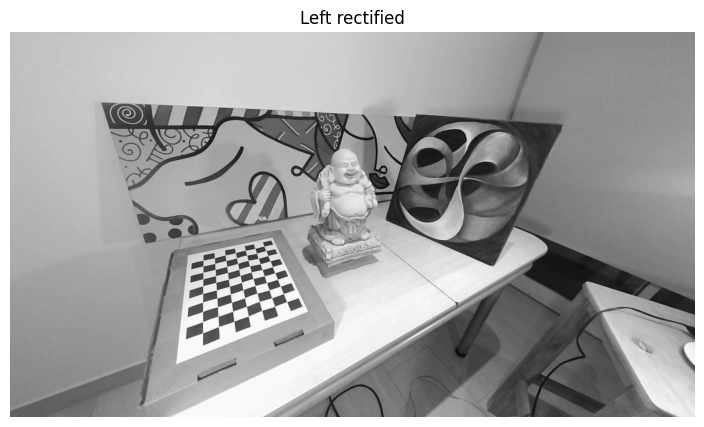

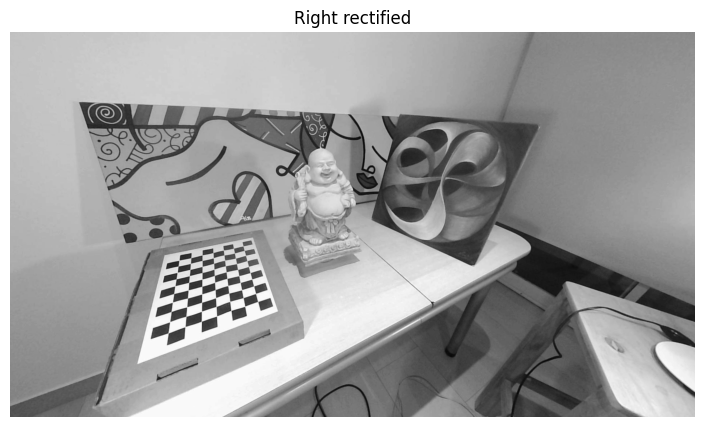

In [5]:
# Rectificación del primer frame
left_img = cv2.remap(left_img_raw, map1x, map1y, cv2.INTER_LINEAR)
right_img = cv2.remap(right_img_raw, map2x, map2y, cv2.INTER_LINEAR)

show(left_img, "Left rectified")
show(right_img, "Right rectified")

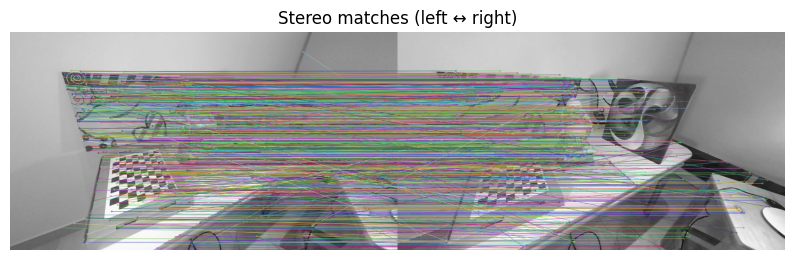

In [6]:
# Extracción y matching de features entre img izq y der
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(left_img, None)
kp2, des2 = sift.detectAndCompute(right_img, None)

# BFMatcher con L2 para SIFT
top_matches = 2000
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = matcher.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)[:top_matches]

# Visualizar matches
img_matches = cv2.drawMatches(left_img, kp1, right_img, kp2, matches, None, flags=2)
show(img_matches, "Stereo matches (left ↔ right)")

Triangulamos los puntos 3D de la primera imagen estereo para tener una referencia inicial. Luego, triangulamos los puntos 3D de la segunda imagen estereo y los agregamos al mapa 3D.

Puntos 3D triangulados: (1550, 3)
Cantidad de puntos 3D triangulados entre (-50000, 50000) en X y (-20000, 20000) en Y: 1545


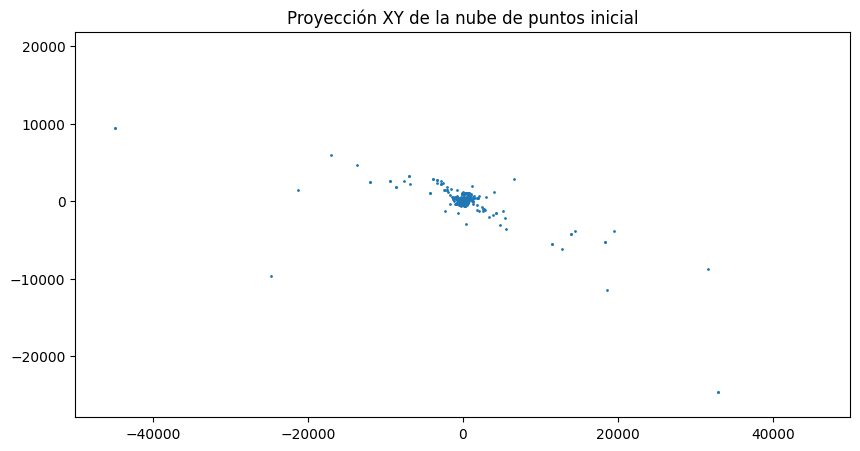

In [7]:
# Preparamos puntos en formato Nx2
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

# Convertir a coordenadas homogéneas para triangulación
pts1_h = cv2.undistortPoints(np.expand_dims(pts1, axis=1), K1, dist1, P=P1)
pts2_h = cv2.undistortPoints(np.expand_dims(pts2, axis=1), K2, dist2, P=P2)

# Triangular
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_h, pts2_h)
points_3d = (points_4d_hom / points_4d_hom[3])[:3].T

print("Puntos 3D triangulados:", points_3d.shape)
num_in_range = np.sum(
    (points_3d[:, 0] >= -50000) & (points_3d[:, 0] <= 50000) &
    (points_3d[:, 1] >= -20000) & (points_3d[:, 1] <= 20000)
)
print("Cantidad de puntos 3D triangulados entre (-50000, 50000) en X y (-20000, 20000) en Y:", num_in_range)

# Visualización simple de la nube de puntos (XY)
plt.scatter(points_3d[:, 0], points_3d[:, 1], s=1)
plt.title("Proyección XY de la nube de puntos inicial")
plt.axis("equal")
plt.xlim(-50000, 50000)
plt.ylim(-20000)
plt.show()

<h1>Segundo par de imágenes estéreo</h1>

primero rectificamos y sacamos los features de la segunda imagen estereo.

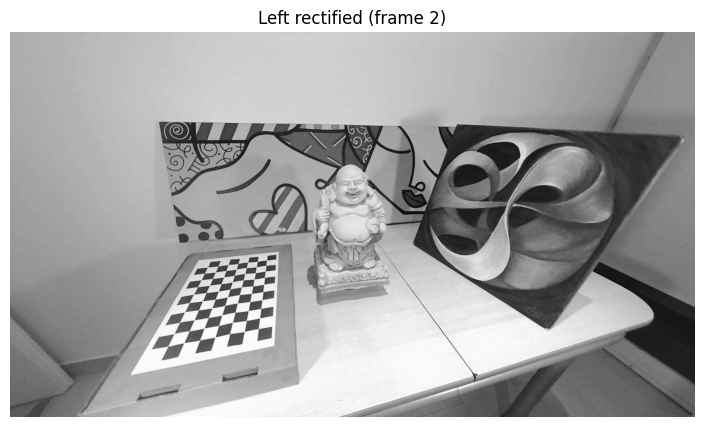

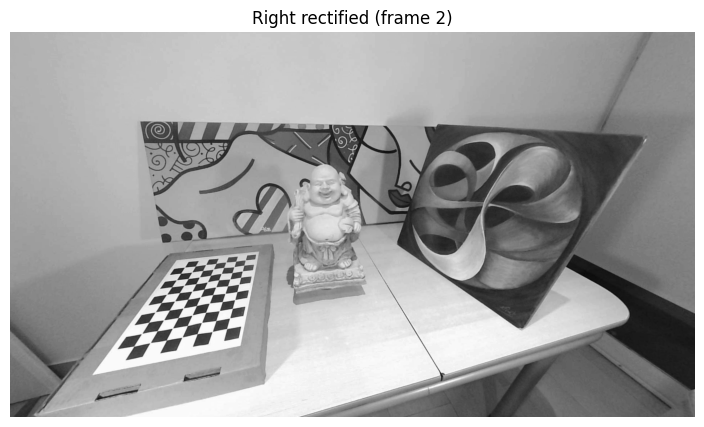

In [8]:
# Rectificación
left_img_path_2 = "datasets/captures/left_1.jpg"
right_img_path_2 = "datasets/captures/right_1.jpg"

left_img_raw_2 = cv2.imread(left_img_path_2, cv2.IMREAD_GRAYSCALE)
right_img_raw_2 = cv2.imread(right_img_path_2, cv2.IMREAD_GRAYSCALE)

left_img_2 = cv2.remap(left_img_raw_2, map1x, map1y, cv2.INTER_LINEAR)
right_img_2 = cv2.remap(right_img_raw_2, map2x, map2y, cv2.INTER_LINEAR)

show(left_img_2, "Left rectified (frame 2)")
show(right_img_2, "Right rectified (frame 2)")

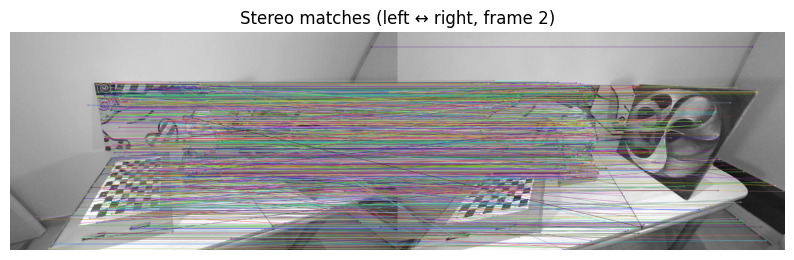

In [9]:
# Extracción y matching de features
sift_2 = cv2.SIFT_create()
kp1_2, des1_2 = sift_2.detectAndCompute(left_img_2, None)
kp2_2, des2_2 = sift_2.detectAndCompute(right_img_2, None)

# BFMatcher con L2 para SIFT
matcher_2 = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_2 = matcher_2.match(des1_2, des2_2)
matches_2 = sorted(matches_2, key=lambda x: x.distance)[:2000]

img_matches_2 = cv2.drawMatches(left_img_2, kp1_2, right_img_2, kp2_2, matches_2, None, flags=2)
show(img_matches_2, "Stereo matches (left ↔ right, frame 2)")

<h3> Asociación de puntos entre frames usando Optical Flow (PyrLK)  </h3>
Vamos a asociar los puntos detectados en la imagen izquierda del frame 1 con la imagen izquierda del frame 2 usando flujo óptico de Lucas-Kanade.

Se asociaron 1414 puntos entre frame 1 y frame 2 (izquierda) usando Optical Flow.


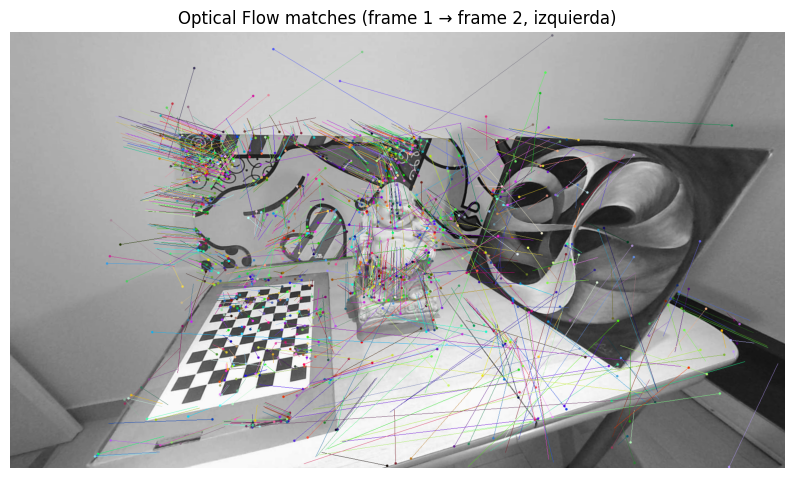

Se asociaron 1402 puntos entre frame 1 y frame 2 (derecha) usando Optical Flow.


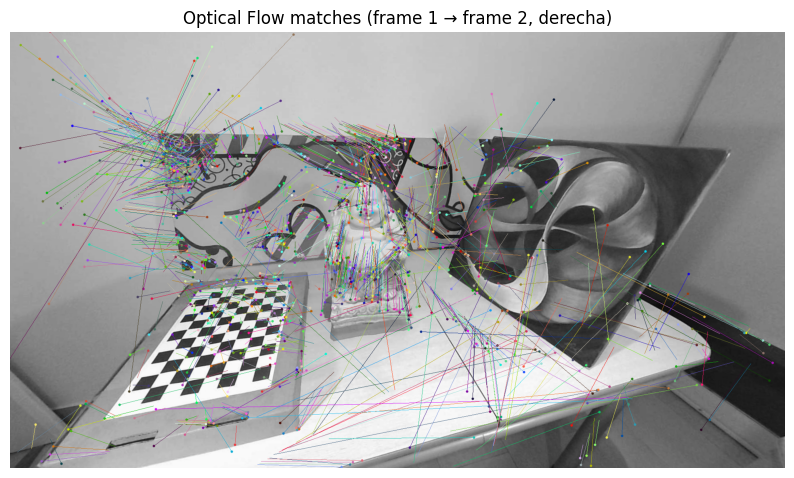

In [10]:
# izq
pts1_left = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2_left, st_left, err_left = cv2.calcOpticalFlowPyrLK(left_img, left_img_2, pts1_left, None)
good_old_left = pts1_left[st_left == 1]
good_new_left = pts2_left[st_left == 1]
print(f"Se asociaron {good_new_left.shape[0]} puntos entre frame 1 y frame 2 (izquierda) usando Optical Flow.")

img_vis_left = cv2.cvtColor(left_img_2, cv2.COLOR_GRAY2BGR)
for i, (new, old) in enumerate(zip(good_new_left, good_old_left)):
    a, b = new.ravel()
    c, d = old.ravel()
    color = tuple(np.random.randint(0, 255, 3).tolist())
    cv2.circle(img_vis_left, (int(a), int(b)), 3, color, -1)
    cv2.line(img_vis_left, (int(a), int(b)), (int(c), int(d)), color, 1)
plt.figure(figsize=(10, 8))
plt.imshow(img_vis_left[..., ::-1])
plt.title('Optical Flow matches (frame 1 → frame 2, izquierda)')
plt.axis('off')
plt.show()

# der
pts1_right = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2_right, st_right, err_right = cv2.calcOpticalFlowPyrLK(right_img, right_img_2, pts1_right, None)
good_old_right = pts1_right[st_right == 1]
good_new_right = pts2_right[st_right == 1]
print(f"Se asociaron {good_new_right.shape[0]} puntos entre frame 1 y frame 2 (derecha) usando Optical Flow.")

img_vis_right = cv2.cvtColor(right_img_2, cv2.COLOR_GRAY2BGR)
for i, (new, old) in enumerate(zip(good_new_right, good_old_right)):
    a, b = new.ravel()
    c, d = old.ravel()
    color = tuple(np.random.randint(0, 255, 3).tolist())
    cv2.circle(img_vis_right, (int(a), int(b)), 3, color, -1)
    cv2.line(img_vis_right, (int(a), int(b)), (int(c), int(d)), color, 1)
plt.figure(figsize=(10, 8))
plt.imshow(img_vis_right[..., ::-1])
plt.title('Optical Flow matches (frame 1 → frame 2, derecha)')
plt.axis('off')
plt.show()

<h3> Estimación de la pose de la cámara izquierda del frame 2 usando PnP </h3>
Asociamos los puntos 3D triangulados en el frame 1 con sus proyecciones 2D en la imagen izquierda del frame 2
(usando el seguimiento por Optical Flow).

In [11]:
# Para la estimación de pose, emparejamos solo los puntos que tienen correspondencia válida
min_len = min(points_3d.shape[0], good_new_left.shape[0]) #para que no falle si hay menos puntos 3D que 2D o viceversa, tomamos el mínimo entre ambos
pts3d_pnp = points_3d[:min_len]
pts2d_pnp = good_new_left[:min_len].reshape(-1, 2)

# Estimación de pose con solvePnP
success, rvec, tvec = cv2.solvePnP(pts3d_pnp, pts2d_pnp, K1, dist1, flags=cv2.SOLVEPNP_ITERATIVE)

if success:
    print("Pose estimada para la cámara izquierda del frame 2:")
    print("Vector de rotación (rvec):", rvec.ravel())
    print("Vector de traslación (tvec):", tvec.ravel())
    # Convertimos a matriz de rotación
    R2, _ = cv2.Rodrigues(rvec)
    print("Matriz de rotación (R2):\n", R2)
else:
    print("No se pudo estimar la pose con PnP. Verifica las correspondencias 2D-3D.")

# El resultado te da la pose de la cámara izquierda del frame 2 respecto al sistema global definido en el frame 1.

Pose estimada para la cámara izquierda del frame 2:
Vector de rotación (rvec): [-2.59991083 -0.41130033 -1.09036447]
Vector de traslación (tvec): [  9846.6436006    1187.0561313  -40249.25844299]
Matriz de rotación (R2):
 [[ 0.67250643  0.36820267  0.64199836]
 [ 0.14753694 -0.91674521  0.37122913]
 [ 0.72523648 -0.1549355  -0.67084054]]


graficamos los puntos 3D triangulados y las cámaras en un sistema de coordenadas 3D para tener una diea de que tan bien nos esta dando

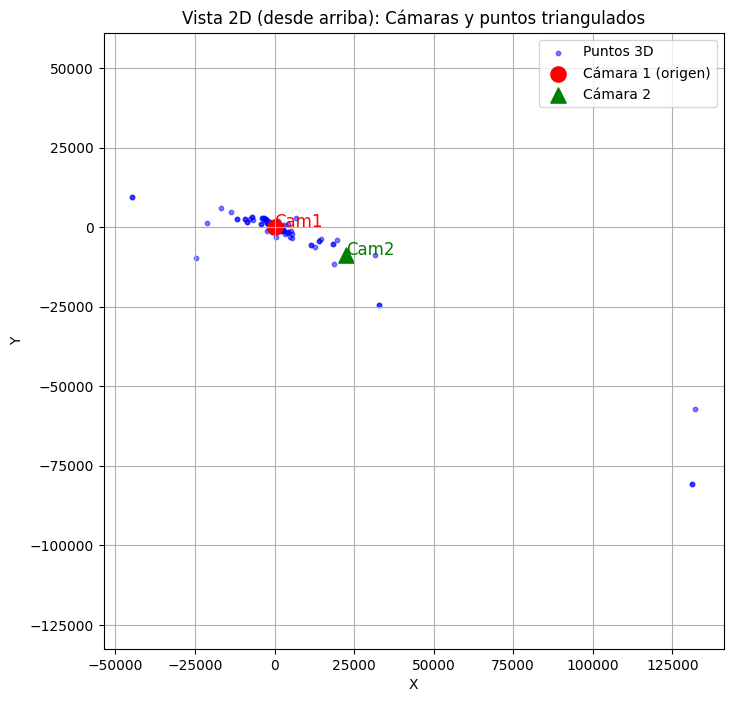

In [12]:
plt.figure(figsize=(8, 8))

# Puntos 3D proyectados en el plano XY
plt.scatter(points_3d[:, 0], points_3d[:, 1], c='b', s=10, alpha=0.5, label='Puntos 3D')

# Cámara 1 (origen)
plt.scatter(0, 0, c='r', marker='o', s=120, label='Cámara 1 (origen)')
plt.text(0, 0, 'Cam1', color='r', fontsize=12)

# Cámara 2 (pose estimada)
cam2_pos = -R2.T @ tvec.reshape(3, 1)
cam2_pos = cam2_pos.ravel()
plt.scatter(cam2_pos[0], cam2_pos[1], c='g', marker='^', s=120, label='Cámara 2')
plt.text(cam2_pos[0], cam2_pos[1], 'Cam2', color='g', fontsize=12)

plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.legend()
plt.title('Vista 2D (desde arriba): Cámaras y puntos triangulados')
plt.grid(True)
plt.show()

<h3> Triangulación de nuevos puntos 3D en el frame 2 </h3>
Triangulamos los puntos 3D de la imagen izquierda del frame 2 que No estaban en el frame 1 y los agregamos al mapa 3D, de esta forma vamos a ir agregando puntos 3D al mapa 3D.

Total keypoints en frame 2 (izq): 3512
Puntos seguidos desde frame 1: 166
Nuevos keypoints en frame 2: 3346
🔹 Nuevos puntos 3D triangulados en frame 2: (1461, 3)


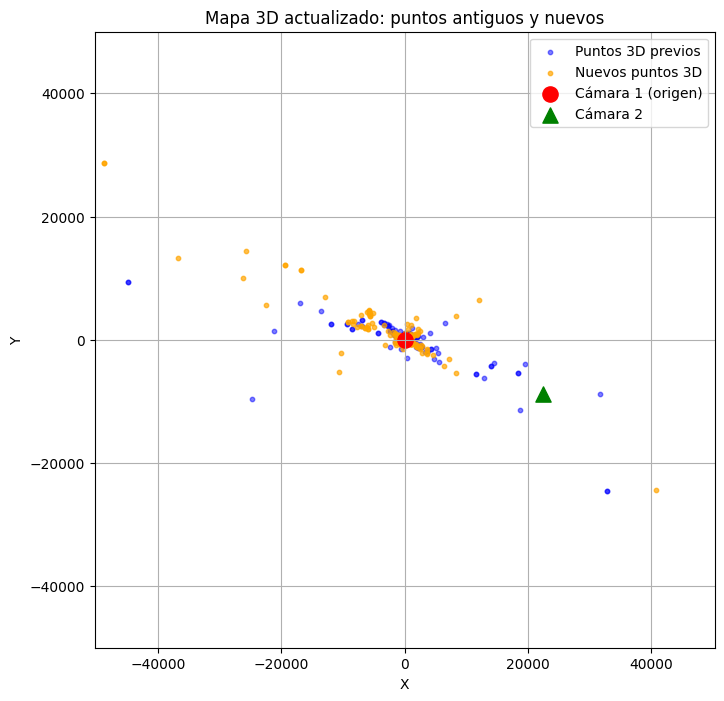

In [13]:
# 1. Identificar keypoints en la izquierda del frame 2 que NO fueron seguidos desde el frame 1
all_kp2_idx = set(range(len(kp1_2)))
# good_new_left contiene los puntos seguidos desde frame 1, buscamos sus posiciones en kp1_2
# para esto, comparamos coordenadas (puede haber pequeñas diferencias, usamos un umbral)
def find_kp_indices(kp_list, pts, thresh=1.0):
    idxs = []
    for pt in pts:
        for i, kp in enumerate(kp_list):
            if np.linalg.norm(np.array(kp.pt) - pt) < thresh:
                idxs.append(i)
                break
    return set(idxs)

tracked_kp2_idx = find_kp_indices(kp1_2, good_new_left)
new_kp2_idx = all_kp2_idx - tracked_kp2_idx

print(f"Total keypoints en frame 2 (izq): {len(kp1_2)}")
print(f"Puntos seguidos desde frame 1: {len(tracked_kp2_idx)}")
print(f"Nuevos keypoints en frame 2: {len(new_kp2_idx)}")

# 2. Para estos nuevos keypoints, buscamos su match estéreo en la derecha (usando matches_2)
new_matches_2 = [m for m in matches_2 if m.queryIdx in new_kp2_idx]

if len(new_matches_2) == 0:
    print("No se encontraron nuevos matches estéreo en frame 2.")
else:
    # 3. Preparamos los puntos para triangulación
    pts1_new = np.float32([kp1_2[m.queryIdx].pt for m in new_matches_2])
    pts2_new = np.float32([kp2_2[m.trainIdx].pt for m in new_matches_2])

    pts1_new_h = cv2.undistortPoints(np.expand_dims(pts1_new, axis=1), K1, dist1, P=P1)
    pts2_new_h = cv2.undistortPoints(np.expand_dims(pts2_new, axis=1), K2, dist2, P=P2)

    # 4. Triangulación
    points_4d_new = cv2.triangulatePoints(P1, P2, pts1_new_h, pts2_new_h)
    points_3d_new = (points_4d_new / points_4d_new[3])[:3].T

    print(f"🔹 Nuevos puntos 3D triangulados en frame 2: {points_3d_new.shape}")

    # 5. Agregamos los nuevos puntos al mapa global
    points_3d_total = np.vstack([points_3d, points_3d_new])

    # Visualización: azul = puntos antiguos, naranja = nuevos
    plt.figure(figsize=(8, 8))
    plt.scatter(points_3d[:, 0], points_3d[:, 1], c='b', s=10, alpha=0.5, label='Puntos 3D previos')
    plt.scatter(points_3d_new[:, 0], points_3d_new[:, 1], c='orange', s=10, alpha=0.7, label='Nuevos puntos 3D')
    plt.scatter(0, 0, c='r', marker='o', s=120, label='Cámara 1 (origen)')
    plt.scatter(cam2_pos[0], cam2_pos[1], c='g', marker='^', s=120, label='Cámara 2')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.legend()
    plt.title('Mapa 3D actualizado: puntos antiguos y nuevos')
    plt.grid(True)
    plt.xlim(-50000, 50000)
    plt.ylim(-50000, 50000)
    plt.show()

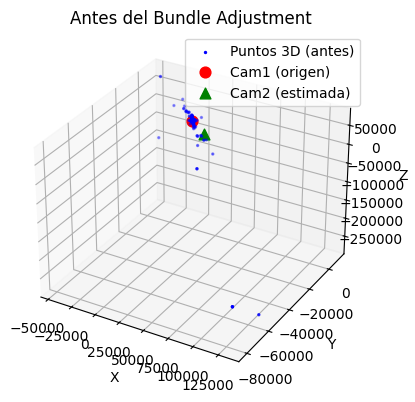

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# --- Antes del Bundle Adjustment ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=2, c='b', label='Puntos 3D (antes)')
ax.scatter(0, 0, 0, c='r', marker='o', s=60, label='Cam1 (origen)')
if 'cam2_pos' in locals():
    ax.scatter(cam2_pos[0], cam2_pos[1], 0, c='g', marker='^', s=60, label='Cam2 (estimada)')
ax.set_title('Antes del Bundle Adjustment')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.grid(True)

<h3> Bundle Adjustment con pycolmap para dos frames </h3>

En esta celda se realiza el ajuste global de las poses y puntos 3D usando pycolmap, que es una librería eficiente y compacta para este tipo de problemas. Se definen las cámaras, las poses iniciales, los puntos 3D y las observaciones 2D, y se ejecuta el BA para refinar todo el sistema.

In [22]:
# 1. Definir la cámara (usamos los parámetros de la izquierda, frame 1)
camera = pycolmap.Camera(
    model='PINHOLE',
    width=image_size[0],
    height=image_size[1],
    params=[K1[0,0], K1[1,1], K1[0,2], K1[1,2]]
)

# 2. Crear el objeto de reconstrucción y agregar la cámara
recon = pycolmap.Reconstruction()
recon.add_camera(camera)

# 3. Crear imágenes y setear sus poses
img1 = pycolmap.Image()
img1.name = 'frame1'
img1.camera_id = camera.camera_id

img2 = pycolmap.Image()
img2.name = 'frame2'
img2.camera_id = camera.camera_id

img1_id = recon.add_image(img1)
img2_id = recon.add_image(img2)

# Cámara 1: origen (identidad)
recon.images[img1_id].qvec = np.array([1, 0, 0, 0], dtype=np.float64)
recon.images[img1_id].tvec = np.zeros(3, dtype=np.float64)

# Cámara 2: usar la estimación de PnP
from scipy.spatial.transform import Rotation as R
qvec2 = R.from_matrix(R2).as_quat()  # (x, y, z, w)
qvec2 = np.roll(qvec2, 1)  # pycolmap espera (w, x, y, z)
recon.images[img2_id].qvec = qvec2.astype(np.float64)
recon.images[img2_id].tvec = tvec.ravel().astype(np.float64)

# 4. Puntos 3D y observaciones
points3D = []
observations = []
for i, pt3d in enumerate(points_3d):
    x1, y1 = pts1[i]
    if i < good_new_left.shape[0]:
        x2, y2 = good_new_left[i].ravel()
        obs = [
            (img1_id, x1, y1),
            (img2_id, x2, y2)
        ]
    else:
        obs = [(img1_id, x1, y1)]
    points3D.append(pt3d)
    observations.append(obs)

for i, (pt3d, obs) in enumerate(zip(points3D, observations)):
    point_id = recon.add_point3D(pt3d, track=[])
    for (image_id, x, y) in obs:
        recon.add_observation(point_id, image_id, x, y)

# 5. Ejecutar Bundle Adjustment
pycolmap.bundle_adjustment(recon)

# 6. Mostrar resultados refinados
print("Pose refinada cámara 1 (debe ser identidad):")
print("qvec:", recon.images[img1_id].qvec)
print("tvec:", recon.images[img1_id].tvec)
print("\nPose refinada cámara 2:")
print("qvec:", recon.images[img2_id].qvec)
print("tvec:", recon.images[img2_id].tvec)
print("\nPrimeros puntos 3D refinados:")
for i, pt in enumerate(recon.points3D.values()):
    print(f"Point {i}: {pt.xyz}")
    if i > 4:
        break

ValueError: [image.h:170] Check failed: camera_id != kInvalidCameraId (4294967295 vs. 4294967295) 

In [ ]:
# --- Después del Bundle Adjustment ---
ax2 = fig.add_subplot(122, projection='3d')
# Extraer puntos 3D refinados
xyz_refined = np.array([pt.xyz for pt in recon.points3D.values()])
ax2.scatter(xyz_refined[:, 0], xyz_refined[:, 1], xyz_refined[:, 2], s=2, c='orange', label='Puntos 3D (después)')
# Cámaras refinadas
ax2.scatter(0, 0, 0, c='r', marker='o', s=60, label='Cam1 (origen)')
tvec2_ref = recon.images[2].tvec
ax2.scatter(tvec2_ref[0], tvec2_ref[1], tvec2_ref[2], c='g', marker='^', s=60, label='Cam2 (refinada)')
ax2.set_title('Después del Bundle Adjustment')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()